*David Schlangen, 2019-04-02*

# Task: Caption Generation

Caption generation is a task with a long tradition in computer vision. (See \cite{Bernardi2016} for a recent-ish overview.) From our perspective, it can be characterised as "say something true about the image" but with the additional constraint that it capture "the essence of the depicted situation". We have already seen examples of captions in the denotations notebook, where we looked at them from the interpretation angle.

From the generation angle, we can see why this has been such a focus in research. In a natural analysis, the task seems to involve the recognition of objects and relations, the determination which of those are salient or essential for the depicted situation, and then expressing the selected ones in the right words -- all of which are tasks that require understanding of the image and of language.

In [1]:
# imports

from __future__ import division
import codecs
import json
from itertools import chain, izip, permutations, combinations
from collections import Counter, defaultdict
import ConfigParser
import os
import random
from textwrap import fill
import scipy
import sys
from copy import deepcopy

from nltk.parse import CoreNLPParser
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Latex, display

pd.set_option('max_colwidth', 250)

In [2]:
# Load up config file (needs path; adapt env var if necessary); local imports

# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = ConfigParser.SafeConfigParser()
with codecs.open(config_path, 'r', encoding='utf-8') as f:
    config.readfp(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('../Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [3]:
# Load up preprocessed DataFrames. Slow!
# These DataFrames are the result of pre-processing the original corpus data,
# as per dsg-vision/Preprocessing/preproc.py

df_names = ['mscoco_bbdf', 'cococapdf', 'cocoent_capdf', 'cocoent_objdf']
df = load_dfs(preproc_path, df_names)

City street during the winter at an intersection.


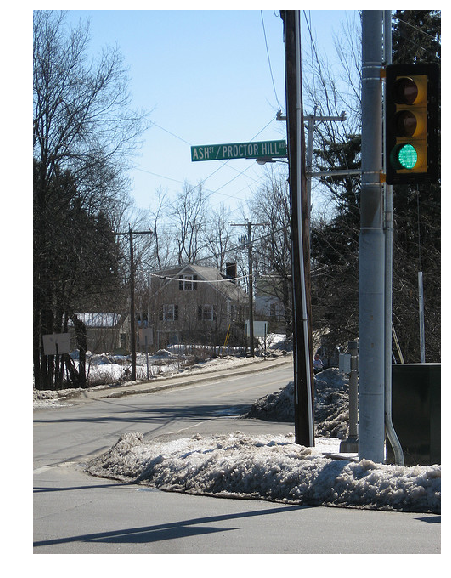

In [4]:
# A caption from COCO, paired with its aligned image
pos = df['cococapdf'].sample()
ic, ii, pos_cap = pos['i_corpus image_id caption'.split()].values[0]
fig, ax = plt.subplots(1,1, figsize=(10, 10))
print pos_cap
plot_img_ax(config, ax, 'mscoco', ii)

Modern captioning methods do not require grounded training data (with links between entities in the caption and regions in the image), but for looking into the factors that determine the content selection by the caption annotators, having those might be useful. In the denotations notebook, I complained that we don't have such groundings for the COCO captions. In the meantime I have found a very recent paper \cite{Cornia2019} that uses automatic methods (parsing of the caption, region detection on the image, and soft linking of the two) to provide at least a noisy (overgenerating) approximation:

In [5]:
# show a coco caption with phrase groundings from COCO Entities
def coco_entcap():
    ic, ii, _, cap, cap_ent = df['cocoent_capdf'][df['cocoent_capdf']['split'] == 'train'].sample().values[0]

    print cap
    print cap_ent
    #fig, ax = plt.subplots(1,1, figsize=(10, 10))
    #plot_img_ax(config, ax, 'mscoco', ii)

    out = []
    for tok in cap_ent.split():
        if '#' in tok:
            ents = tok.split('#')[2]
            if ',' in ents:
                out.extend([int(e) for e in ents.split(',')])
            elif ents != '_':
                out.append(int(ents))
    #print out

    bbs = query_by_id(df['cocoent_objdf'], (ic, ii), 'region_id bb type'.split())
    bbs_to_plot = []
    for this_rid in out:
        bb, ent_type = bbs[bbs['region_id'] == this_rid][['bb', 'type']].values[0]
        bbs_to_plot.append((bb, '{} {}'.format(this_rid, ent_type)))

    if os.path.isfile(get_image_filename(config, ic, ii)):
        plot_labelled_bb(get_image_filename(config, ic, ii), bbs_to_plot)
    #plot_labelled_bb(get_image_filename(config, ic, ii), bbs[['bb', 'type']].values)
    
coco_entcap()

a green street sign sitting below a large tree
[a green street sign]#sign#0,15 sitting below [a large tree]#tree#2,3,4,6,7,11,20


thinly sliced pizza is sitting on a white plate
[thinly sliced pizza]#pizza#6 is sitting on [a white plate]#plate#2,4,5


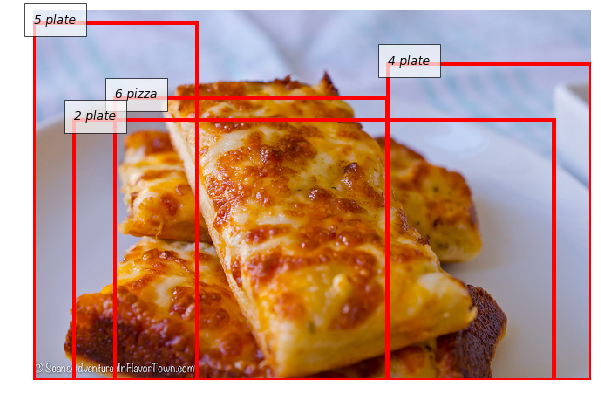

In [6]:
coco_entcap()

Note: The regions here have been created automatically. One could also try to do the linking with COCO entities first, and only if no appropriate ones are available (remember that there are only 80 different categories, and that the captions might mention others) go for automatically detected regions of interest. Or at the very least, it would be useful to align these automatically created regions with COCO regions.

# References

[<a id="cit-Bernardi2016" href="#call-Bernardi2016">1</a>] Bernardi Raffaella, Cakici Ruket, Elliott Desmond <em>et al.</em>, ``_Automatic Description Generation from Images: A Survey of Models, Datasets, and Evaluation Measures_'', ArXiv, vol. , number , pp. 1--34,  2016.  [online](http://arxiv.org/abs/1601.03896)

[<a id="cit-Cornia2019" href="#call-Cornia2019">2</a>] M. Cornia, L. Baraldi and R. Cucchiara, ``_Show, Control and Tell: A Framework for Generating Controllable and Grounded Captions_'', CVPR 2019,  2019.  [online](http://arxiv.org/abs/1811.10652)

